
 #### K-평균 알고리즘
 #### 군집화(Cluster) 문제를 풀기 위한 비지도 학습 알고리즘
 #### ※ 지도학습 : 데이터 라벨링하는 작업. 특정 데이터를 입출력하는 것을 반복해서 학습시키는 방식
 #### 주어진 데이터를 진정된 군집 개수(K)로 그룹화하여 한 그룹내의 동일한 성질을 가지고 다른 그룹과 차별화 시키는 것.
 #### 알고리즘의 결과는 중심(centroid) 라고 부르는 K 개의 점(dot) 으로, 이들은 각기 다른 그룹의 중심점을 나타낸다.
 #### k-평균 클러스터링 알고리즘은 클러스터링 방법 중 분할법에 속한다. 
 #### 분할법은 주어진 데이터를 여러 파티션 (그룹) 으로 나누는 방법이다. 
 #### 예를 들어 n개의 데이터 오브젝트를 입력받았다고 가정하자. 
 #### 이 때 분할법은 입력 데이터를 n보다 작거나 같은 k개의 그룹으로 나누는데, 
 #### 이 때 각 군집은 클러스터를 형성하게 된다. 다시 말해, 데이터를 한 개 이상의 데이터 오브젝트로 구성된 
 #### k개의 그룹으로 나누는 것이다. 
 #### 이 때 그룹을 나누는 과정은 거리 기반의 그룹간 비유사도 (dissimilarity) 와 같은 비용 함수 (cost function) 을 
 #### 최소화하는 방식으로 이루어지며, 
 #### 이 과정에서 같은 그룹 내 데이터 오브젝트 끼리의 유사도는 증가하고, 
 #### 다른 그룹에 있는 데이터 오브젝트와의 유사도는 감소하게 된다.
 #### [7] k-평균 알고리즘은 각 그룹의 중심 (centroid)과 그룹 내의 데이터 오브젝트와의 거리의 
 #### 제곱합을 비용 함수로 정하고, 이 함수값을 최소화하는 방향으로 각 데이터 오브젝트의 
 #### 소속 그룹을 업데이트 해 줌으로써 클러스터링을 수행하게 된다.


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [40]:
num_porints = 2000
vectors_set = []

for i in range(num_porints):
    if np.random.random() > 0.5:
        vectors_set.append([
            np.random.normal(0.0, 0.9),
            np.random.normal(0.0, 0.9)
            ])
    else:
        vectors_set.append([
            np.random.normal(3.0, 0.5),
            np.random.normal(1.0, 0.5)
            ])

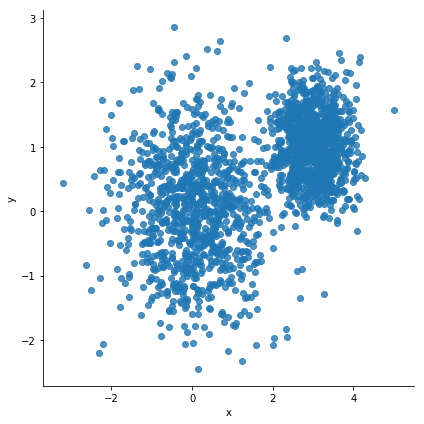

In [41]:
df = pd.DataFrame({
    "x": [v[0] for v in vectors_set],
    "y": [v[1] for v in vectors_set]
    })
sns.lmplot("x", "y", data=df, fit_reg=False, height=6)

plt.show()

In [42]:
vectors = tf.constant(vectors_set) # 모든 데이터를 텐서로 옮긴다 -> vectors 변수에 테서-상수 로 선언

In [43]:
k = 4 # 입력데이터에서 무작위로 K개의 데이터를 선택함. 여기서는 4개
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], [k, -1]))
# K개의 데이터 포인터는 2D 텐서로 저장됨

In [44]:
print('---------- 텐서의 구조 보기 ----------')
print('vectors')
print(vectors.get_shape())  # (2000, 2)
# D0 차원의 크기가 2000개이고 D1 차원은 크기가 2(각 점의 x, y 좌표) 
print('centroids')
print(centroids.get_shape())  # (4, 2)
# 센트로이드는 D0 차원의 크기가 4개이고 D1 차원은 vectors 와 동일한 2인 행렬

---------- 텐서의 구조 보기 ----------
vectors
(2000, 2)
centroids
(4, 2)


In [45]:
expanded_vectors = tf.expand_dims(vectors, 0)  # 두 텐서에 차원을 추가
expanded_centroids = tf.expand_dims(centroids, 1) # 두 텐서를 2차원에서 3차원으로 만들어 뺄셈 가능하도록
print(expanded_vectors.get_shape())
print(expanded_centroids.get_shape())

(1, 2000, 2)
(4, 1, 2)


In [47]:
# 크기를 맞추는 작업
# 각 점에 대한 유클리드 제곱거리 알고리즘 무한 반복
#assignments = tf.argmin(tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)),2),0)
#assignments = tf.argmin(tf.reduce_sum(tf.square(expanded_vectors - expanded_centroids),2),0) # 위 스크립트와 같음. 압서 expand_dims 에서 뺄 수 있게 구조를 잡아주었음.

diff = tf.subtract(expanded_vectors, expanded_centroids) # 각 벡터값과 중심의 차이
sqr = tf.square(diff) # diff 텐서의 제곱값
distances = tf.reduce_sum(sqr, 2) # 매개 변수로 지정한 차원(D2) 가 줄어듬
assignments = tf.argmin(distances, 0) # tf.argmin() 중심 값들이 들어있는 D0 차원에서 가장 작은 값은 인덱스 리턴


In [48]:
# 새로운 중심 계산하기
# 매 반복마다 새롭게 그룹화를 하면서 각 그룹에 해당하는 새로운 중심을 다시 계산
means = tf.concat([
    tf.reduce_mean(tf.gather(vectors, tf.reshape(tf.where(tf.equal(assignments,c)), [1,-1])), reduction_indices=[1]) for c in range(k)
    ], 0)

# reshape 함수에 사용된 -1 은 나누어 떨어지는 숫자를 자동으로 적용하겠다는 뜻
# 행과 열, 페이지에서 중심이 되는 것을 지정한 다음에, 자동 계산시키기 위해 사용

print('means')
print(means)
print(means.get_shape())


update_centroids = tf.assign(centroids, means)

print('update_centroids')
print(update_centroids)
print(update_centroids.get_shape())

init_op = tf.global_variables_initializer()

means
Tensor("concat_2:0", shape=(4, 2), dtype=float32)
(4, 2)
update_centroids
Tensor("Assign_2:0", shape=(4, 2), dtype=float32_ref)
(4, 2)


In [233]:
sess = tf.Session()
sess.run(init_op)

for step in range(100):
    _, centroid_values, assignment_values = sess.run([update_centroids, centroids, assignments])
    # assignment_values 텐서의 결과를 확인하기 위한 결과 그림 그리기
print(assignment_values[0])
print(vectors_set[i])

1
[2.4949498912392776, 2.0077856080722913]


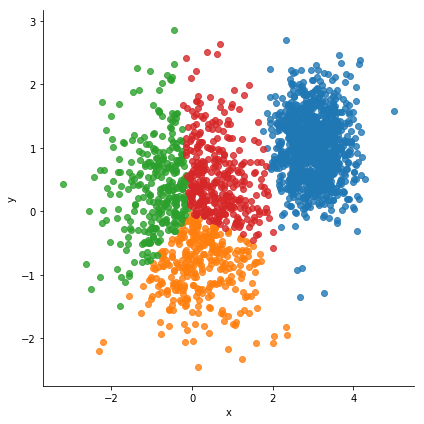

In [86]:
data = {"x": [], "y": [], "cluster": []}

for i in range(len(assignment_values)):
    data["x"].append(vectors_set[i][0])
    data["y"].append(vectors_set[i][1])
    data["cluster"].append(assignment_values[i])


df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, fit_reg=False,height=6, hue="cluster", legend=False)
plt.show()